In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [2]:
train_dir = 'train/'
test_dir = 'test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

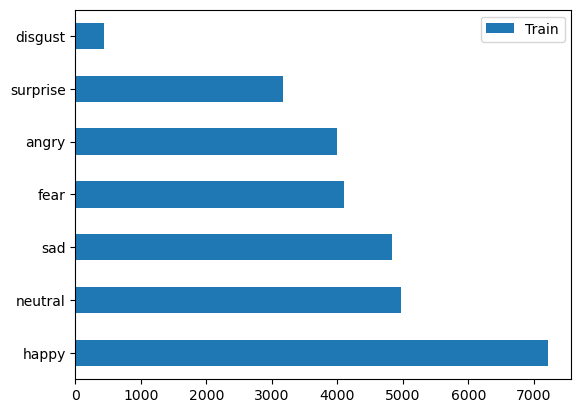

In [4]:
Train_Count.plot(kind='barh')

<Axes: >

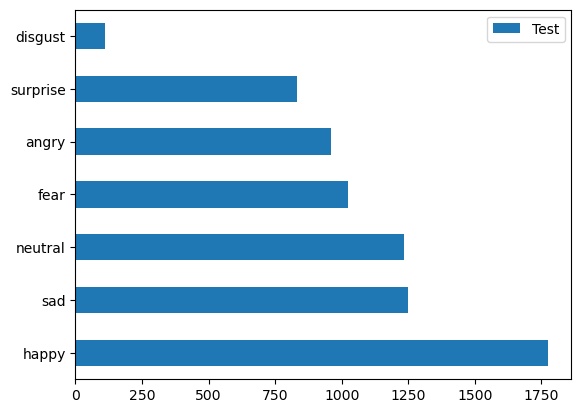

In [5]:
Test_Count.plot(kind='barh')

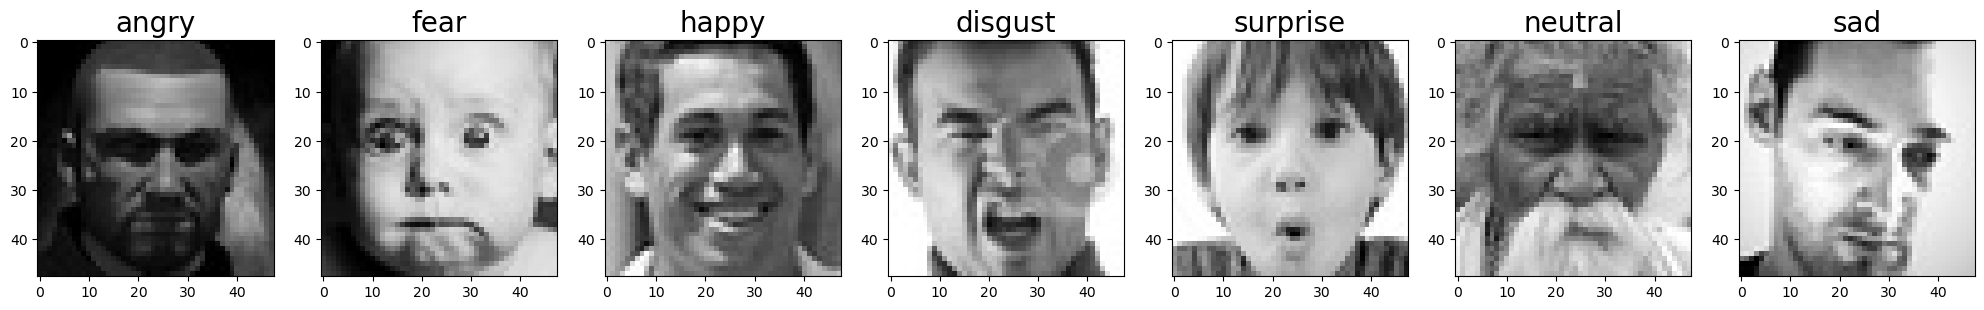

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = 'train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [7]:
img_shape = 48
batch_size = 64
train_data_path = 'train/'
test_data_path = 'test/'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [9]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                        

**Specifying Callbacks**

In [11]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [12]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50


2024-02-28 06:38:21.389183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 44s 76ms/step - loss: 2.0049 - accuracy: 0.2125 - val_loss: 1.8122 - val_accuracy: 0.2556 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 33s 73ms/step - loss: 1.7549 - accuracy: 0.2935 - val_loss: 1.6247 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 33s 73ms/step - loss: 1.6146 - accuracy: 0.3654 - val_loss: 1.5508 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 33s 74ms/step - loss: 1.4969 - accuracy: 0.4247 - val_loss: 1.9264 - val_accuracy: 0.1744 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 34s 75ms/step - loss: 1.4150 - accuracy: 0.4545 - val_loss: 1.4928 - val_accuracy: 0.4106 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 33s 73ms/step - loss: 1.3489 - accuracy: 0.4843 - val_loss: 1.6957 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 33s 73ms/step -

# **Evaluating CNN Model**

In [13]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 3s 23ms/step - loss: 0.9378 - accuracy: 0.6512
    Test Loss: 0.93777
Test Accuracy: 65.12%


In [14]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

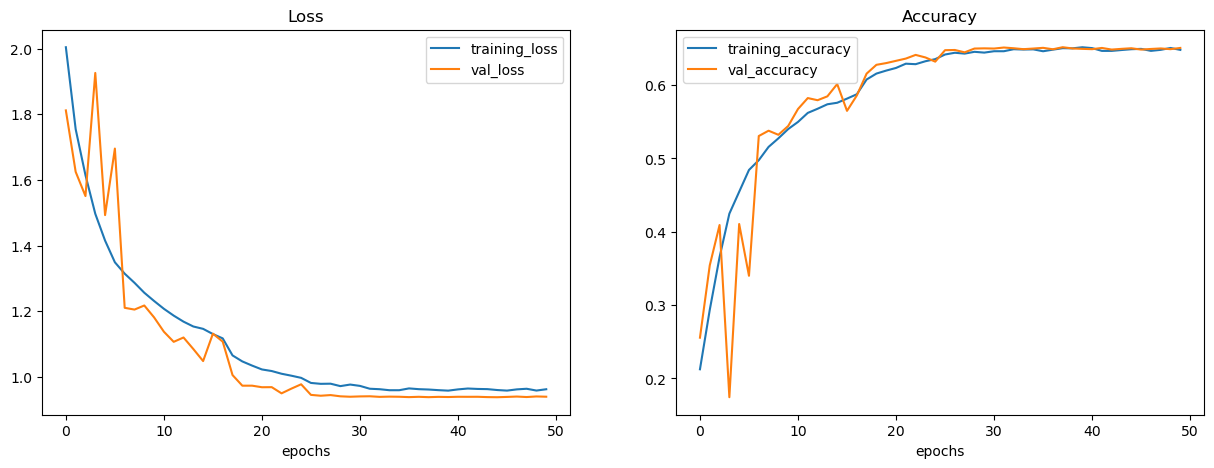

In [15]:
plot_curves(CNN_history)

In [16]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 [==============================] - 3s 20ms/step


In [17]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

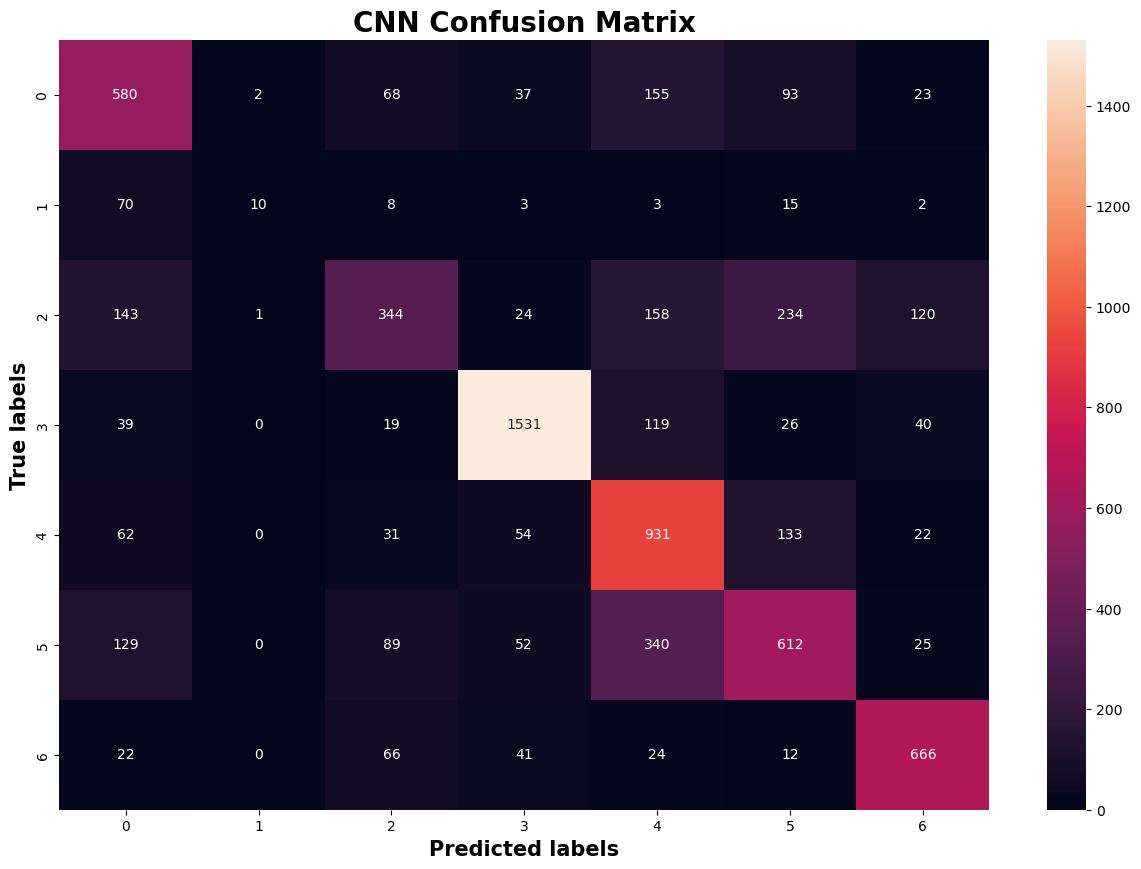

In [18]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

In [19]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = 'train/'
test_data_path = 'test/'

In [20]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [21]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94668760/94668760 [==============================] - 1s 0us/step


In [22]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [23]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [24]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Ba  (None, 7, 7, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Ba  (None, 64)                256       
 tchNormalization)                                    

**Specifying Callbacks**

In [25]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [26]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30


2024-02-28 07:07:36.259732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - 318s 681ms/step - loss: 1.5343 - accuracy: 0.4687 - val_loss: 1.3015 - val_accuracy: 0.5345 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - 302s 674ms/step - loss: 1.2118 - accuracy: 0.5601 - val_loss: 6.9623 - val_accuracy: 0.5047 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 1.1670 - accuracy: 0.5778
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [==============================] - 303s 676ms/step - loss: 1.1670 - accuracy: 0.5778 - val_loss: 1.5689 - val_accuracy: 0.6004 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - 300s 670ms/step - loss: 1.0342 - accuracy: 0.6230 - val_loss: 0.9734 - val_accuracy: 0.6409 - lr: 2.0000e-04
Epoch 5/30
448/448 [==============================] - 303s 677ms/step - loss: 0.9825 - accuracy: 0.6456 - val_loss: 0.9469 - val_accuracy: 0.6544 - lr: 2.0000e-04
Epoch 6/30
448/448 [==========================

# **Evaluating ResNet50V2**

In [27]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 12s 104ms/step - loss: 0.8989 - accuracy: 0.6806
    Test Loss: 0.89893
Test Accuracy: 68.06%


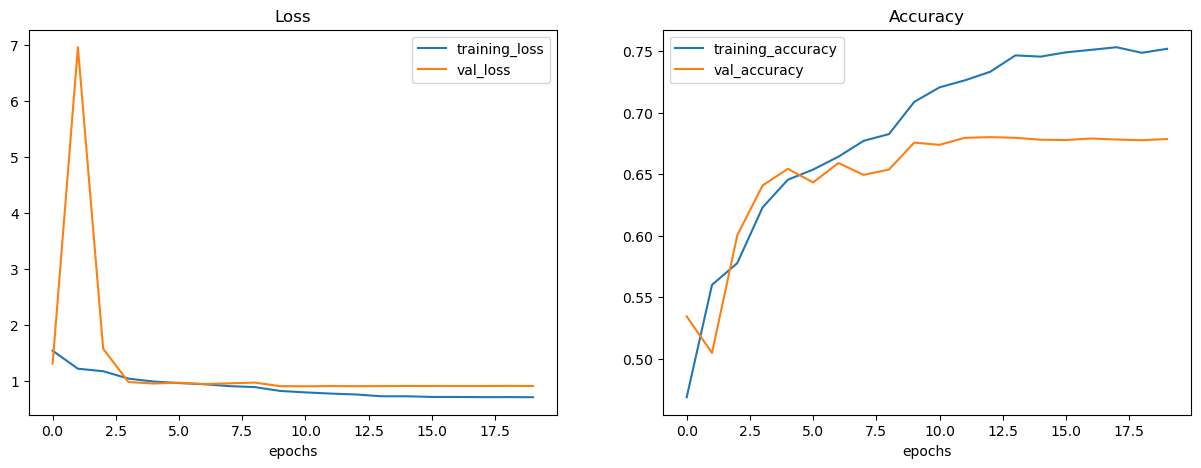

In [28]:
plot_curves(ResNet50V2_history)

In [29]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 11s 91ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

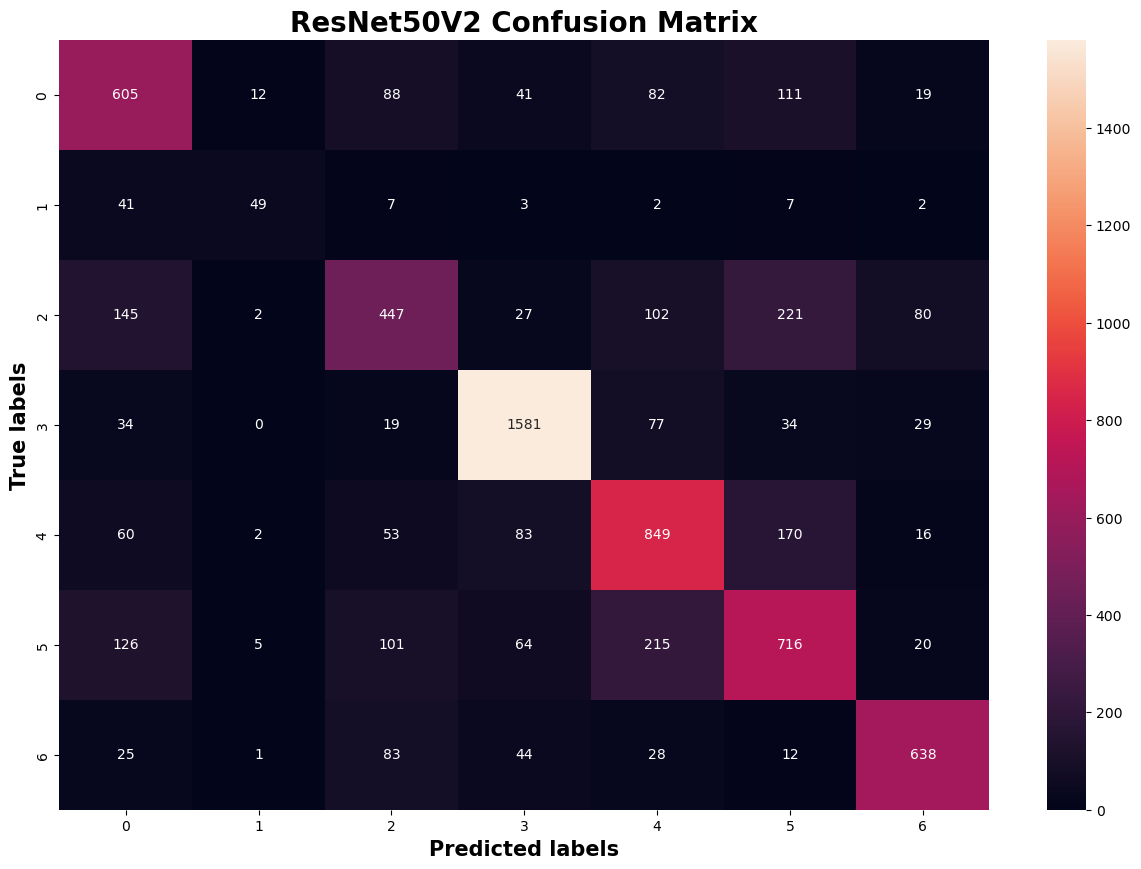

In [30]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [31]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [32]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

In [102]:
# Display 10 random pictures from the dataset with their labels
""""
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()
"""

'"\nRandom_batch = np.random.randint(0, len(test_generator) - 1)\n\nRandom_Img_Index = np.random.randint(0, batch_size - 1 , 10)\n\nfig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),\n                        subplot_kw={\'xticks\': [], \'yticks\': []})\n\nfor i, ax in enumerate(axes.flat):\n\n    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]\n\n    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])\n\n    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))\n\n    ax.imshow(Random_Img)\n\n    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:\n          color = "green"\n    else:\n          color = "red"\n    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)\nplt.show()\nplt.tight_layout()\n'

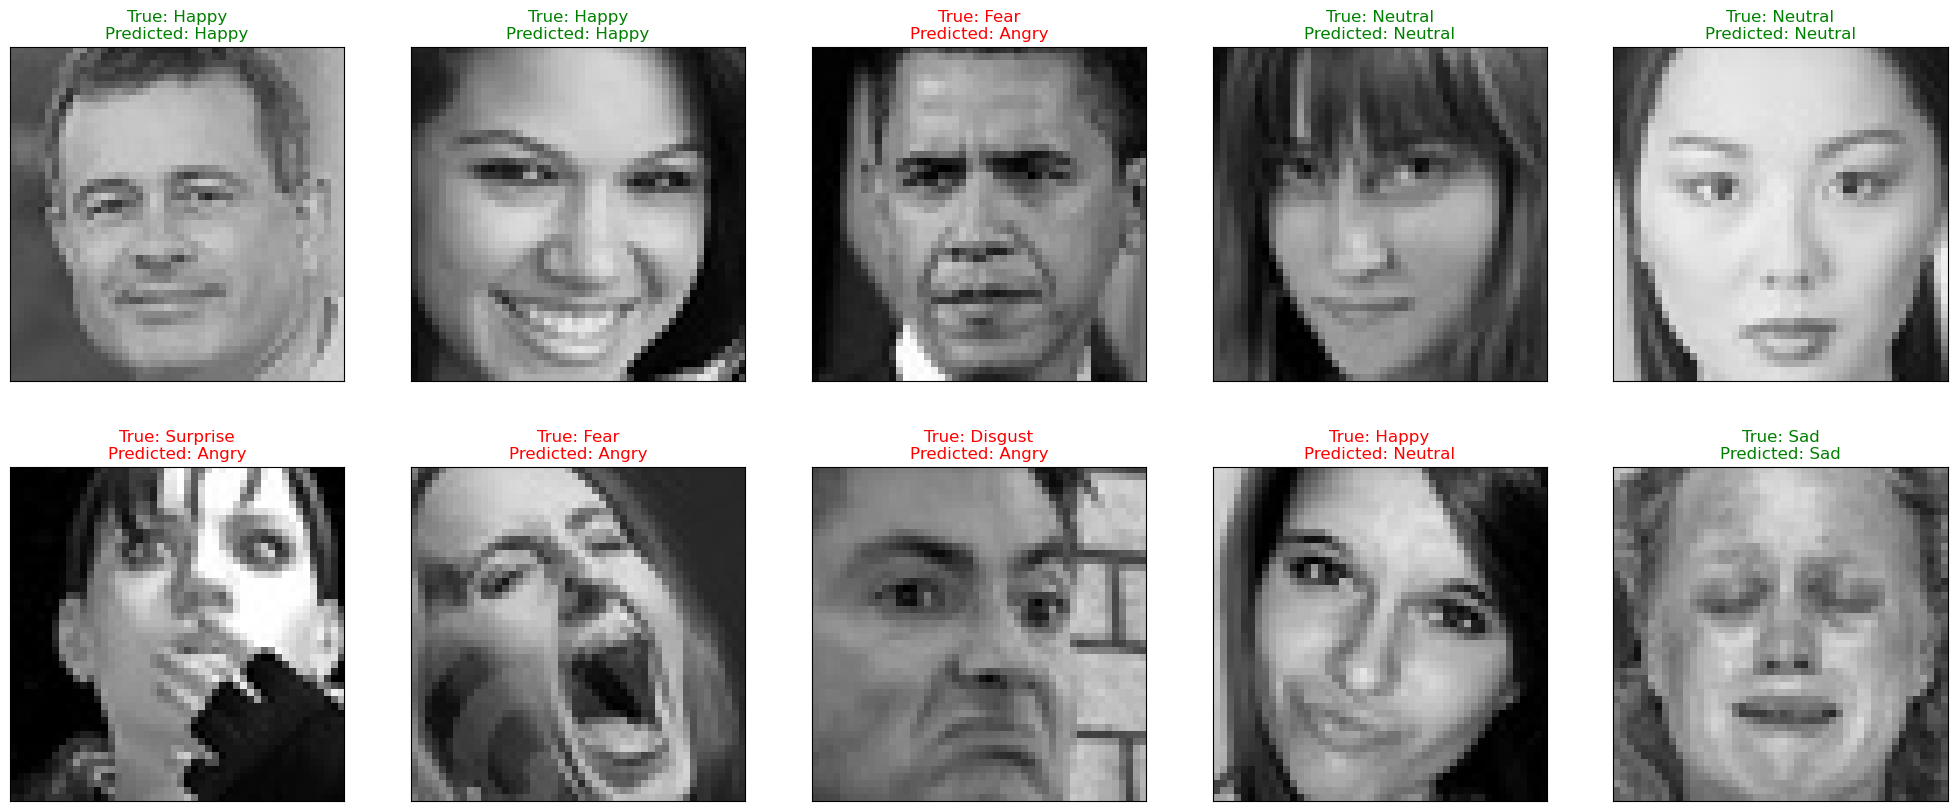

<Figure size 640x480 with 0 Axes>

In [40]:
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
# Your existing code...
for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    
    # Resize the image to the expected input size (48, 48)
    Random_Img_Resized = tf.image.resize(Random_Img, [48, 48])
    
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    
    # Make sure to use the resized image for prediction
    Model_Prediction = np.argmax(CNN_Model.predict(tf.expand_dims(Random_Img_Resized, axis=0), verbose=0))
    
    # Ensuring the image is in the correct format and range for displaying
    # This assumes your images were normalized in the [0, 1] range. Adjust accordingly if not.
    Random_Img_Display = (Random_Img_Resized.numpy() * 255).astype("uint8")
    
    ax.imshow(Random_Img_Display)
    
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


**ResNet50V2 Predictions**

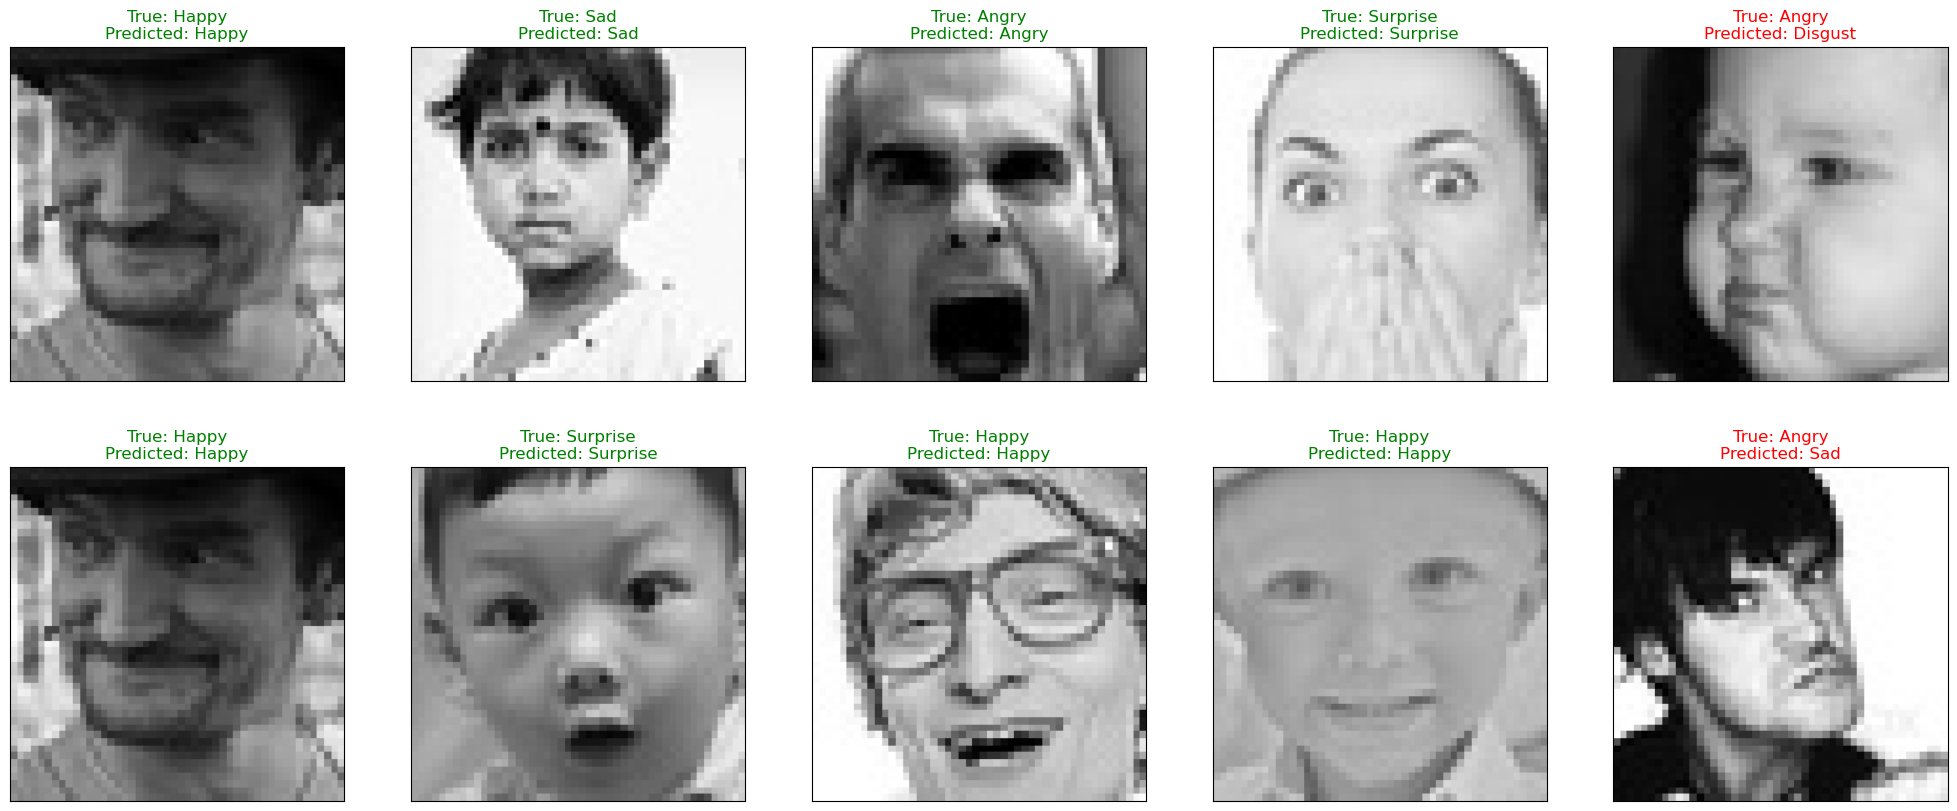

<Figure size 640x480 with 0 Axes>

In [41]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Player**

In [92]:
Music_Player = pd.read_csv("songs1.csv")
Music_Player = Music_Player[['Name','Artist','Mood']]
Music_Player.head()

,Name,Artist,Mood
0,Tum Hi Ho,Arijit Singh,Sad
1,Agar Tum Saath Ho,"Alka Yagnik, Arijit Singh",Sad
2,Chaiyya Chaiyya,"Sukhwinder Singh, Sapna Awasthi",Happy
3,Dil Diyan Gallan,Atif Aslam,Sad
4,Mere Sapno Ki Rani,Kishore Kumar,Happy


In [93]:
Music_Player["Mood"].value_counts()

Sad          46
Happy        32
Energetic    24
Calm         19
Vibrant       1
Club          1
Name: Mood, dtype: int64

In [94]:
Play = Music_Player[Music_Player['Mood'] =='Calm' ]
#Play = Play.sort_values(by="Popularity", ascending=False)
Play = Play.sample(n=5).reset_index(drop=True)
Play = Play[:5].reset_index(drop=True)
display(Play)

,Name,Artist,Mood
0,Tera Yaar Hoon Main,Arijit Singh,Calm
1,Galliyan,Ankit Tiwari,Calm
2,Raabta (Title Track),"Arijit Singh, Nikhita Gandhi",Calm
3,Bulleya,"Amit Mishra, Shilpa Rao",Calm
4,Moh Moh Ke Dhaage,"Papon, Monali Thakur",Calm


In [95]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['Mood'] =='Sad' ]
        #Play = Play.sort_values(by="Popularity", ascending=False)
        Play = Play.sample(n=5).reset_index(drop=True)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['Mood'] =='Happy' ]
        #Play = Play.sort_values(by="Popularity", ascending=False)
        Play = Play.sample(n=5).reset_index(drop=True)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['Mood'] =='Calm' ]
        #Play = Play.sort_values(by="Popularity", ascending=False)
        Play = Play.sample(n=5).reset_index(drop=True)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['Mood'] =='Energetic' ]
        #Play = Play.sort_values(by="Popularity", ascending=False)
        Play = Play.sample(n=5).reset_index(drop=True)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [47]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
    
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")    

--2024-02-28 09:17:27--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

100%[======================================>] 930,127     --.-K/s   in 0.008s  

2024-02-28 09:17:27 (107 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [96]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [97]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    #plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    
    Recommend_Songs(pred_class)

1/1 [==============================] - 0s 28ms/step


,Name,Artist,Mood
0,Chaiyya Chaiyya,"Sukhwinder Singh, Sapna Awasthi",Happy
1,Tera Ban Jaunga,"Akhil Sachdeva, Tulsi Kumar",Happy
2,Pinga,"Shreya Ghoshal, Vaishali Made",Happy
3,Veere,Vishal Mishra,Happy
4,Jab Tak,Armaan Malik,Happy


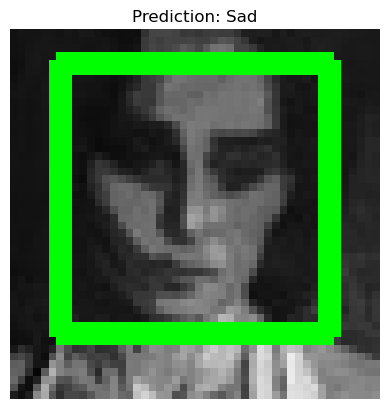

In [101]:
pred_and_plot("test/sad/PrivateTest_13472479.jpg", Emotion_Classes) # with CNN

In [51]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg" -O sad.jpg

--2024-02-28 09:18:17--  https://pbs.twimg.com/media/EEY3RFFWwAAc-qm.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 146.75.32.159, 2606:2800:220:13d:2176:94a:948:148e
Connecting to pbs.twimg.com (pbs.twimg.com)|146.75.32.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36922 (36K) [image/jpeg]
Saving to: ‘sad.jpg’

100%[======================================>] 36,922      --.-K/s   in 0s      

2024-02-28 09:18:17 (98.9 MB/s) - ‘sad.jpg’ saved [36922/36922]



1/1 [==============================] - 0s 29ms/step


,Name,Artist,Mood,Popularity
0,Malang,Ved Sharma,Happy,88
1,Badtameez Dil,Benny Dayal,Happy,87
2,Kabhi Kabhi Aditi,Rashid Ali,Happy,84
3,Vaaste,"Dhvani Bhanushali, Nikhil Dï¿½ï¿½ï¿",Happy,91
4,Namo Namo,Amit Trivedi,Happy,87


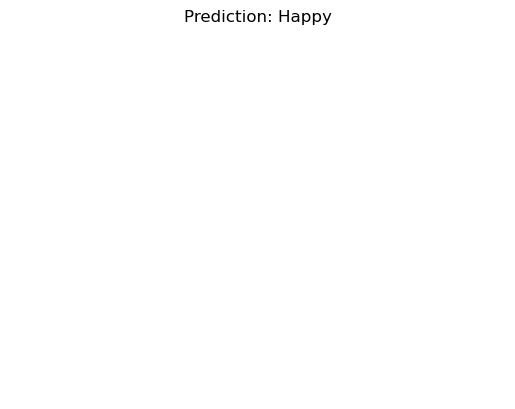

In [88]:
pred_and_plot("happy.jpg", Emotion_Classes) # with CNN

1/1 [==============================] - 0s 30ms/step


,Name,Artist,Mood,Popularity
0,Zara Zara,Bombay Jayashri,Calm,95
1,Kun Faya Kun,"A. R. Rahman, Javed Ali, Mohit Chauhan",Calm,90
2,Kabhi Jo Badal Barse,Arijit Singh,Calm,84
3,Kabira (Encore),"Arijit Singh, Harshdeep Kaur",Calm,92
4,Tera Yaar Hoon Main,Arijit Singh,Calm,85


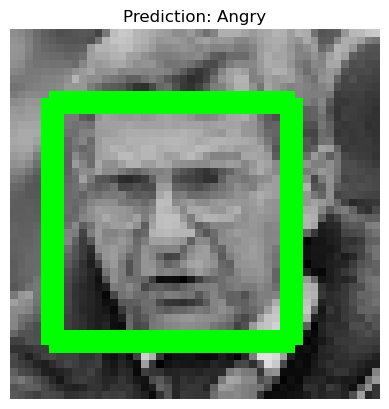

In [89]:
pred_and_plot("test/angry/PrivateTest_22126718.jpg", Emotion_Classes) # with ResNet50V2

In [55]:
# Downloading Image to Test On
!wget -c "https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg" -O happy.jpg 

--2024-02-28 09:19:09--  https://pbs.twimg.com/profile_images/758370732413947904/xYB5Q3FY_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.173.16, 2606:2800:220:13d:2176:94a:948:148e
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.173.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-02-28 09:19:09 ERROR 404: Not Found.



1/1 [==============================] - 0s 28ms/step


,Name,Artist,Mood
0,Bulleya,"Amit Mishra, Shilpa Rao",Calm
1,Kabira,"Rekha Bhardwaj, Tochi Raina",Calm
2,Iktara,"Kavita Seth, Amitabh Bhattacharya",Calm
3,Safar,Arijit Singh,Calm
4,Moh Moh Ke Dhaage,"Papon, Monali Thakur",Calm


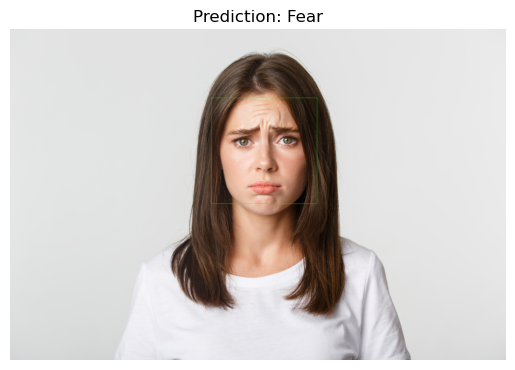

In [133]:
pred_and_plot("sad1.jpg", Emotion_Classes) # with ResNet50V2

1/1 [==============================] - 0s 30ms/step


,Name,Artist,Mood
0,Munni Badnaam Hui,"Mamta Sharma, Aishwarya",Happy
1,Malang,Ved Sharma,Happy
2,Enna Sona,Arijit Singh,Happy
3,Mere Sapno Ki Rani,Kishore Kumar,Happy
4,Pinga,"Shreya Ghoshal, Vaishali Made",Happy


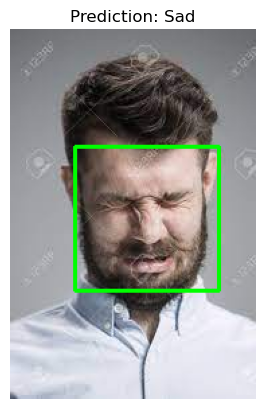

In [145]:
pred_and_plot("cry.jpeg", Emotion_Classes) # with ResNet50V2

In [135]:
# Assuming your model is a TensorFlow/Keras model
import tensorflow as tf

# Define the directory and model name
model_dir = 'emotion_model'
version = '1'
export_path = os.path.join(model_dir, version)

# Save the model
tf.saved_model.save(CNN_Model, export_path)


INFO:tensorflow:Assets written to: emotion_model/1/assets


INFO:tensorflow:Assets written to: emotion_model/1/assets


In [149]:
import boto3

s3 = boto3.resource('s3')
s3.Bucket('emotion-buckets').upload_file('model.tar.gz', 'model.tar.gz')

In [150]:
from sagemaker.tensorflow import TensorFlowModel

sagemaker_model = TensorFlowModel(
    model_data='s3://emotion-buckets/model.tar.gz',
    role='arn:aws:iam::292264923209:role/service-role/AWSGlueServiceSageMakerNotebookRole-test',  # Replace with your IAM role
    framework_version='2.0'  # Replace with your TensorFlow version
)


In [151]:
predictor = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


----!